# Lecture 5 - Read quality assessment and blast searches for contamination or target proteins

This is a short tutorial to introduce you to read quality assessment and cleaning following different strategies adapted to different read types: short from Illumina and long from PacBio. We will first look at the read quality as downloaded from NCBI. then, we will carry out cleaning of adapter sequences and other features that affect downstream analyses, followed by a second quality assessment to evaluate improvement.  

In the second part of the tutorial, we will use blastn searches to identify read contamination. Sequencing primers, adapters, or barcodes are not the only source of data contamination. It is almost impossible to not have some bacterial contamination, or even human contamination!. Identifying reads that do not belong to our genome of interest is a key step before formal genome assembly. Here, we will learn how to create a database of sequences that can be contaminations and how to run local blastn to single-out that contamination when present on the data.  

In the third part of the tutorial, we will learn to use the same blastn strategies to identify bacteria from environmental data. The method is useful for ecological monitorying or the discovery of unknown organisms from eDNA (amongst other applications). We will take the strategy beyond and use blastx searches to check if we can identify toxin-antitoxin proteins present (or absent?) in the same environmental data.  

**The data:**
We will clean reads from six sequencing runs derived from six species of [*Takifugu*](https://en.wikipedia.org/wiki/Takifugu) fish, the vertebrate with the smallest genome known up to this date. The environmental data is a sequencing run from water samples taken from the bottom of the Baltic sea.  

---


## 1. Prepare the environment

This time we are installing only a few packages. **We will be working with two environments (due to conflicts and conda's struggle with solving environments wihtin an hour), so please pay attention to the steps for deactivating and activating the specific environment needed for each step.**  

### **1.1 Read cleaning/download environment:**

In [ ]:
%%bash

# update conda
conda update -n base conda

# creating environment
conda create -n biogenomics -c bioconda blast fastp spades fastqc
conda activate biogenomics
conda install -c bioconda multiqc

cd ~;

# if you forgot how to get the file and don't have it in your computer:
wget https://ftp-trace.ncbi.nlm.nih.gov/sra/sdk/3.0.6/sratoolkit.3.0.6-ubuntu64.tar.gz
tar xvzf sratoolkit.3.0.6-ubuntu64.tar.gz

# continue here if you already have sratoolkit
cd sratoolkit.3.0.6-ubuntu64/bin/;
FASTDUMP="$PWD/fastq-dump";
echo $FASTDUMP;

# check
$FASTDUMP --help

### **1.2 Long read draft assembly environment:**


for this, we are using a different program. Spades does hybrid assembly but is not recommended for long reads only [**Flye**](https://www.nature.com/articles/s41587-019-0072-8) is an assembler with basic functionalities that relies on repeat-graphs. Good for low-coverage long-read data (<10-20x). [**Canu**](https://genome.cshlp.org/content/early/2017/03/15/gr.215087.116) is better if not comparable. Canu supports read correction with short reads but requires higher-coverage data (>20x)

In [ ]:
%%bash

# deactivate the active environment and go back to base
conda deactivate

conda create -n flye flye;
conda activate flye # to activate that particular environment

### **1.3 Blobtools for detection of contamination and genome QC:**

This environment is very useful for summarising and visualising data from blast searches and taxonomic assigment of draft assemblies for identifying contamination and filtering contigs and reads. It uses [Blobtools v1.1](https://github.com/DRL/blobtools) and [Blobtoolkit](https://github.com/blobtoolkit/blobtoolkit). You can check their main papers [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7144090/), [here](https://f1000research.com/articles/6-1287/v1), and [here](https://www.frontiersin.org/articles/10.3389/fgene.2013.00237/full).

don't worry if you cannot install this easily or if you don't manage to do this during the lecture. You can try running this section of the tutorial on your own.

GitHub blobtools: https://github.com/DRL/blobtools

conda create -n blobtools
activate blobtools
git clone blobtools


In [ ]:
%%bash

conda deactivate
conda create -n blobtools blobtools
conda activate blobtools
conda install -c conda-forge firefox geckodriver
conda install -c anaconda matplotlib docopt tqdm wget pyyaml git
conda install -c bioconda pysam --update-deps
conda install -c bioconda minimap2
conda install -c bioconda samtools

# go back to your working directory
# just modify your path to reflect your folder hierarchy
cd /mnt/c/Users/username/Documents/lecture4

# create the folders
mkdir short long meta blobtools

cd blobtools/

# get the taxdump data from NCBI
wget ftp://ftp.ncbi.nlm.nih.gov/pub/taxonomy/taxdump.tar.gz -P data/
tar zxf data/taxdump.tar.gz -C data/ nodes.dmp names.dmp
blobtools nodesdb --nodes data/nodes.dmp --names data/names.dmp

# get the taxonomic database for the "sscinames" to work
wget ftp://ftp.ncbi.nlm.nih.gov/blast/db/taxdb.tar.gz
tar zxf taxdb.tar.gz

### 1.4 Download data and organise folders

We will be working with six [*Takifugu*](https://en.wikipedia.org/wiki/Takifugu) species during this and the rest of the tutorials. The assemblies and quality assessments we generate during this tuturial will be used in future tutorials. Please run the jobs and try to get the data. Because we have limited computing resources, each student **must** choose one species only (but if you feel like you can do the rest, go ahead, but you must work with the species you choose too).  

*Takifugu bimaculatus* SRR21290998 **Urtė Glibauskaitė** (use -k 77 or 55 but 77 might be better)  

*Takifugu rubripes* SRR8586007 **Konstanty Keda** (use -k 77)  

*Takifugu obscurus* SRR8586040 **Zhumasseit Meruyert** (use -k 77)  

*Takifugu alboplumbeus* DRR322254 **Kristupas Paulius** (use -k 77)  

*Takifugu xanthopterus* SRR12009775 **Deividas Vilutis** (use -k 121)  

*Takifugu vermicularis* DRR322281 **Mafe Torres** (use -k 77)  


We can post our choices in the learning environment during class.

In [ ]:
%%bash

# go back to your working directory
# just modify your path to reflect your folder hierarchy
cd /mnt/c/Users/username/Documents/lecture4

# activate the appropriate environment!
conda deactivate
conda activate biogenomics

<div class="alert alert-block alert-warning">
<b>Attention:</b> ONLY DOWNLOAD THE SRA FILES FOR THE ID YOU CHOSE!
</div>

In [ ]:
%%bash

cd short

$FASTDUMP --split-3 SRR21290998
$FASTDUMP --split-3 SRR8586007
$FASTDUMP --split-3 SRR8586042
$FASTDUMP --split-3 DRR322254
$FASTDUMP --split-3 SRR12009775
$FASTDUMP --split-3 DRR322281

<div class="alert alert-block alert-warning">
<b>Attention:</b> Everyone should download the long reads and the metagenome sample reads. If you don't have enough space, focus on the metagenome reads
</div>

In [ ]:
%%bash

# metagenomic data
cd ../meta
$FASTDUMP --split-3 SRR18246873

# long-read data form PacBio
cd ../long
$FASTDUMP --split-3 SRR7881557

---

## 2. Pre-cleaning read quality assessment

Whether you generate the reads yourself or you download them from databases like NCBI's SRA, the first step to a good assembly is to understand the biases in the reads and to correct them. We can generate a report of the read quality and main characteristics using [FastQC](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/). FastQC was mainly designed for short reads but it can be applied to long reads too (although more suitable tools for long reads are available)

In [ ]:
%%bash

# you should have at least two fastq in your folder
# for your each read sense from the Illumina pair-end sequencing experiment

cd ../short
ls *fast

# create a folder for fastqc's output
# the folder must exist for fastqc to run
mkdir fastqc_pre fastqc_post

# This is the fastqc command for a single fastq file
# create a loop to run the command in both fastq files within the folder
fastqc -o fastqc_pre --nogroup sample.fastq;

**Solution** hidden here (but seriously, try doing it yourself first.
<!-- 

# The loop should look like this

for fastq in *fastq; do
    echo $fastq;
    fastqc -o fastqc_pre --nogroup $fastq;
done

-->

For now, you are working with a single sample and two files but there will be times when you will have to check the quality of multiple read files. Fortunately, it is possible to aggregate all results in a single html file using [MultiQC](https://github.com/ewels/MultiQC). The reports generated by FastQC and MultiQC follow the same format and metrics an they can be interpreted in the same manner.

Something else to keep in mind when doing QC on reads is that sequencing methods and technologies have different expectations relating read length, %GC content distribution, etc. It is not the same to look at reads from a single genome and individual and reads form a metagenomic experiment. In the first, we expect an even distribution of GCs and TAs (guanine/cytosine and thymine/adenine), in the second, we cannot expect the distribution of all four nucleotides to be correlated as we have completely different organisms represented by different proportions of reads. If you are interested in knowing what QC for your data should be, you can look at the [MultiQC example reports](https://multiqc.info/example-reports/).

FastQC also has some examples reorts of [good reads](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/good_sequence_short_fastqc.html), [bad reads](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/bad_sequence_fastqc.html), and [read runs contaminated with dimers or primers](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/RNA-Seq_fastqc.html).

In [ ]:
%%bash

# check that output was generated:
ls fastqc_pre/

# generate an aggregated report including all samples:
# multiqc only needs the output path and the input folder path where all fastqc files are:

multiqc -o ./fastqc_pre/ ./fastqc_pre/

<div class="alert alert-block alert-success">
<b>TO DO: </b>Compare the pre-cleaning QC report obtained from your asigned reads to the examples available onlye (MultiQC and FastQC links above) and describe the main differences. Do you think your reads are ok? Are they of low quality? How repetitive? Add your answers to <i>answersL4_name.txt</i>. The answer can be short and to the point.</div>

---

## 3. Read cleaning and post-cleaning QC


Raw reads can contain features inherent to the sequencing technology and the sequencing methods. For example, if we run a whole-genome, paired-end sequencing experiment in a NovaSeq Illumina machine and S4 flowcell, then we know we expect:

- Two sets of reads, one forward and one reverse, that are generated from the same template cluster  
- Reads will be on average 150 base pairs  
- Partial adapter sequences in the 3’ ends of reads (except for reads prepared with Nextera Mate Pair library prep kits, which might have adapters in both ends). Adapters allow read fragments to bind to the flowcell surface and contain the barcodes to identify individual libraries pooled for sequencing. Sequencing starts at the first base of the DNA insert and moves form 5' to 3'. If the DNA insert size is shorter than expected, sequencing will continue downstream the insert and into the adapters in the 3', which results in the reads having partial adapter sequences in that end. [More info here](https://knowledge.illumina.com/software/general/software-general-reference_material-list/000002905)
- Depending on the sequencing technology and particularly those with two-channel sequencing systems (two colours encoding four nucleotides), you migth expect stretches of [poly-g](https://support.illumina.com/content/dam/illumina-support/help/Illumina_DRAGEN_Bio_IT_Platform_v3_7_1000000141465/Content/SW/Informatics/Dragen/PolyG_Trimming_fDG.htm) (guanine homopolymers) or poly-x (any nucleotide). Poly-g, for example, happens when the reads are too short and no more nucleotides are adhered to the expanding strand (the one being sequenced) resulting in no signal for the rest of the sequencng cycles. Because "no signal" encodes for guanine nucleotides... short fragments result in reads with the short insert sequenced and a rown of guanines incorrectly called. The homopolymers, if not removed, will mess up with your assemblies making them very fragmented and difficult to solve.

So, with this all in mind, you need to undertand the type of data you have and think about the best scheme for cleaning your reads. You can also do several rounds of cleaning with quality assessments in between until you are happy or until your draft assemblies look better. This, of course, takes time and resources, but it is worth for ensuring the quality of your results and research.

[Fastp](https://github.com/OpenGene/fastp) is a great piece of software for cleaning reads, faster than traditional (but still good) cleaning programs like [Trimmomatic](https://bioinformatics-core-shared-training.github.io/Bulk_RNAseq_Course_Nov22/Bulk_RNAseq_Course_Base/Markdowns/S3_Trimming_Reads.html) and it can deal with a great deal of cleaning requirements.

Before running the command below, check the program's help menu and read all the options. Think of the scenarios for which every option (or combination thereof) is more appropriate.

The *illumina_adapters.txt* is available in the learning environment or in [here](https://gist.githubusercontent.com/photocyte/3edd9401d0b13476e60f8b104c2575f8/raw/7e1e7e3dac674c196d8a05169558b675a57b7e23/Sequencing_adaptors.fasta). Download it or copy-paste into a file created with `nano`. **Make sure you place the file within the `short` folder or that you write the path on the code**

Also, reads the commens in the code.

In [ ]:
%%bash

# this is a loop to run fastp in all read files
# MODIFY THE CODE TO RUN ONLY ON YOUR SAMPLE
# RUN THE METAGENOME READS TOO! That is sample SRR18246873
# ADJUST THE NUMBER OF THREADS TO FIT YOUR COMPUTER RESOURCES. GO FOR 2 IF IS NOT TOO GREAT

# in the 'short' folder
for sample in SRR21290998 SRR8586007 SRR8586042 DRR322254 SRR12009775 DRR322281; do
    fastp -i ${sample}_1.fastq -I ${sample}_2.fastq \
    -o ${sample}_clean_1.fastq -O ${sample}_clean_2.fastq \
    --adapter_fasta illumina_adapters.txt --detect_adapter_for_pe \
    --dedup --trim_poly_g --trim_poly_x \
    --low_complexity_filter --thread 4;
done

# if you want to clean the long reads
# this is a loop because of convenience but you should write a script and execute it
# using local numbered variables to pass different files to the same script every time you need

cd ../long

for sample in SRR7881557; do
    fastp -i ${sample}.fastq -o ${sample}_clean.fastq \
    --trim_poly_g --trim_poly_x \
    --low_complexity_filter --thread 4;
done

# RUN THE METAGENOMIC DATA
# again, modify this script to make it work with a single file
# or create a script to do run it

cd ../meta
for sample in SRR18246873; do
    fastp -i ${sample}_1.fastq -I ${sample}_2.fastq \
    -o ${sample}_clean_1.fastq -O ${sample}_clean_2.fastq \
    --trim_poly_g --trim_poly_x \
    --thread 4;
done

**Solution** hidden here (but seriously, try doing it yourself first.
<!-- 

# The loop should look like this

fastp -i SRR21290998_1.fastq -I SRR21290998_2.fastq \
-o SRR21290998_clean_1.fastq -O SRR21290998_clean_2.fastq \
--adapter_fasta illumina_adapters.txt --detect_adapter_for_pe \
--dedup --trim_poly_g --trim_poly_x \
--low_complexity_filter --thread 4;


the script can be:
# within the file:
nano fastp_cleaning.sh
------
#!/bin/bash

# $1 is the sample or file suffix
# $2 is the number of threads

fastp -i ${1}_1.fastq -I ${1}_2.fastq \
    -o ${1}_clean_1.fastq -O ${1}_clean_2.fastq \
    --trim_poly_g --trim_poly_x \
    --thread 4;
echo "done"
-------
# change permission
chmod 777 fastp_cleaning.sh 

# execute like:

./fastp_cleaning.sh SRR18246873 4
-->

<div class="alert alert-block alert-success">
<b>TO DO: </b>Check fastp help in the command line. What does <i> --low_complexity_filter</i> do? Add your answers to <i>answersL4_name.txt</i>. The answer can be short.</div>

Once the reads are cleaned, it is time to run a post-cleaning quality check. Use the same code you already wrote for running `FastQC` and `MultiQC` and use as output folder the `fastqc_post` folder

<div class="alert alert-block alert-success">
<b>TO DO: </b>Compare the pre- and post-cleaning MultiQC reports. What changed? Are your reads clean or do you need further cleaning rounds? Add your answers to <i>answersL4_name.txt</i>. The answer can be short.</div>

---

## 4. Detecting contamination from draft assemblies using local blast searches


There's another problem on raw data that needs to be addressed before proceeding with assembling. That issue is exogenous contamination. You will be surprised by the amount of "extra stuff" that makes it into a sample during DNA/RNA extraction or library preparation. In additon to that, samples are rarely pure and often contain additional organisms. Plant samples commonly have fungi in their surface. Insects will have bacteria, fungi, and viruses in their digestive systems. Your lab might be contaminated with a phage that gets sequenced every time you sequence your plasmids (if the phage didn't kill your colonies first). All that "stuff" gets sequenced: reads will come from these exogenous sources. You need to identify contaminant reads and remove them before assembly, otherwise your assembly will only be a chimera of different organisms glued together.

A great example of that happening is the assembly of the Tardigrade genome and """"""the discovery of horizontal gene transfer"""""" (multiple quotes intended). The key message here was that horizontal gene transfer might just be junk on your reads. You can learn the gossip [here](http://nematodes.org/blog/slow-and-steady-a-second-tardigrade-genome/) and check [this amazing paper](https://www.pnas.org/doi/full/10.1073/pnas.1600338113) (if you do, you will become familiar with the plots we will generate). Two more papers that are equally interesting are [here](https://peerj.com/articles/1839/) and [here](https://www.pnas.org/doi/full/10.1073/pnas.1525116113).

Anyways, if we want to follow a similar cleaning process to that in [Koutsovoulos et al., (2016)](https://www.pnas.org/doi/full/10.1073/pnas.1600338113) we will have to do a couple of extra steps: **1)** generating a draft genome, nothing fancy; **2)** mapping the reads back to the draft assembly to get coverage information; and **3)** run a blastn/blastx search to identify the taxonomic affiliation of the contigs within our assemble.

Because of space and time limitations, we will follow the steps to identify bacterial contamination in our fish reads. Fish eat and live in the water and we will hopefully find something there.

Regarding our draft assembly, our intention is to generate sequences longer than a read (which will have millions of hits by chance just because of their length) so that we can classify the draft contigs (likely very fragmented) into endogenous (fish, or at least vertebrate) and exogenous contamination (bacteria).

Cleaning data of exogenous contamination should be a common practice for ancient sample experiments and human/primate evolution studies, and a practice that needs to become common when assembling any other type of data.

### 4.1 Getting draft assemblies

We will be dealing with assemblies later during the course but it is good to get used to them already. The idea is to generate draft assemblies, usually without applying fancy read correction models or additional features to get long contigs. What we want here is to get contigs longer than a read that we can pin-point as contaminant. We will then remove the reads that make those contigs and hopefully, move on to do better assemblies.

We will be using [SPAdes](https://github.com/ablab/spades) by [Bankevich et al., (2012)](https://pubmed.ncbi.nlm.nih.gov/22506599/). SPAdes is not the only assembler out there but is one that in my experience, is faster, more flexible in accepting different sequencing inputs and formats, and verbose, meaning that it is easier to throubleshoot. Because of its flexibility and the algorithms implemented, it is suitable for a wide range of read depths and error rates. It also has a great approach for building [de Bruijn graphs](https://en.wikipedia.org/wiki/De_Bruijn_graph) using several [*kmer sizes*](https://en.wikipedia.org/wiki/K-mer) and not just one, improving the length of contigs. For SPAdes protocols, you can check [Prjibelski et al., (2020)](https://currentprotocols.onlinelibrary.wiley.com/doi/abs/10.1002/cpbi.102).

We will talk about de Bruijn graphs and kmer sizes in other lectures, for now, let's build the draft assemblies.

**Remember:** This step is computationally expensive and requires a lot of RAM that your computer migth not have. Focus on generating the draft genome for the sample you chose from the begining of the exercise. **If you can, try assembling the metagenomic data too**. If SPAdes finishes with an error, **read the error** and if it is related with **not being able to allocate memory**, then increase the kmer size `-k` from 77 to 79 or up to 81. **Note that the kmer size should always be odd**.

If you do the long-read assembly, note that we are not using SPAdes but [Flye](https://github.com/fenderglass/Flye). Flye and [CANU](https://genome.cshlp.org/content/27/5/722) are common long-read assemblers with the capacity to do read correction by adding Illumina sequences. We are choosing Flye because of its speed and memory consumption, but in many cases, you will need to explore when CANU or Flye are more appropriate (e.g. depending on the depth-coverage or your reads).

In [ ]:
%%bash

# safety measure
conda deactivate; conda activate biogenomics

sample='' # add your sample number here

# short reads and metagenomic data
# -k is the kmer size
spades.py -k 77 -t 4 \
    --pe1-1 ${sample}_clean_1.fastq --pe1-2 ${sample}_clean_2.fastq \
    --only-assembler -o "${sample}"_out;

# using flye to assemble long reads

conda deactivate
conda activate flye

cd ../long
flye --pacbio-raw SRR7881557.fastq -g 400m \
    --asm-coverage 2 \
    -i 1 -t 4 -m 1000 -o long_draft

### 4.2 Mapping reads back to the draft assembly

Done with the draft assembly, we can continue by mapping the reads back to the assembly. You can find a lot of files in the output folder resulting from the assemblage. If all went well, you will find a `scaffolds.fasta` file within the `*_out` folder for your sample. You can have a look at the rest of the files and folders to have a guess about what they are.

Meanwhile, make sure you map the **clean** reads that you used for the draft assembly agaisnt the assembly you got.

In [ ]:
%%bash

# switch environments
conda deactivate; conda activate blobtools

# map the reads you used for the assembly back to the assembly
# go to the short folder if you are not there already
cd ../short 
# for example
minimap2 -t 4 -x sr SRR21290998_out/scaffolds.fasta SRR21290998_clean_1.fastq SRR21290998_clean_2.fastq -a > cov_SRR21290998.bam

# map the reads from the metagenome data to the assemblied scaffolds (likely short)
cd ../meta
minimap2 -t 4 -x sr SRR18246873_out/scaffolds.fasta SRR18246873_clean_1.fastq SRR18246873_clean_2.fastq -a > cov_SRR18246873.bam

# if you assembled the long reads:
cd ../long
minimap2 -t 4 -n 1 -K 100 -x map-pb long_draft/assembly.fasta SRR7881557.fastq -a > cov_SRR7881557.bam


### 4.3 Local blast+ searches

#### 4.3.1 Getting data to build the local subject database

Creating the local databases for blast+ searches is easy, but it takes time and space; however, local searchers are more reliable since they don't depend on internet connectivity or who overwhelmed the servers are. It is also unfeasible to incorporate blast+ searches through the internet within a bioiformatic pipeline, particularly for large searches.

To carry out local searches, we first need to download the subject sequences depending on our research question. Then, we use those sequences to build the subject database.

You can modify the `esearch` and `efetch` commands to filter the databases according to your research needs. The sequences need to be in fasta file for building the database.

**You don't need to execute the following `esearch` and `efetch` commands right now**. I have done it for you already and the database files are available in the learning environment or [here](https://doi.org/10.5281/zenodo.8413560). The step takes a while and has a heavy space footprint. Keep in mind that the databases I built are not complete (e.g. if we are looking for Bacteria, the database doesn't include all the sequences available for Bacteria) and they are built to be light for the tutorial. If you have enough space, you can download the fasta files and create the database yourself. Otherwise, I am providing all the necesary files through the learning environment or [here](https://doi.org/10.5281/zenodo.8413560).

Getting the Bacteria sequences first:

In [ ]:
%%bash

conda deactivate
conda activate biogenomics

# blastn looking for contamination and for presence of bacteria in the metagenomic data
# first, download the sequences to create the database
# according to NCBI's taxonomy database, bacteria have the taxon id :

# we are keeping this files in the meta folder

cd ../meta

esearch -db nuccore -query "txid2[Organism]" | efetch -format fasta > bacteria.fasta;

Now getting the protein sequences:

In [ ]:
%%bash

# toxin-antitoxing proteins
esearch -db protein -query "txid2[Organism] AND toxin-antitoxin[Titl]" | efetch -format fasta > toxin.fasta;
esearch -db protein -query "toxin[Titl]" | efetch -format fasta > toxinAll.fasta;

Once all data is downloaded and ready, we can use the following code to create three databases. One with bacteria nucleotide information to run [blastn](https://blast.ncbi.nlm.nih.gov/Blast.cgi?PROGRAM=blastn&BLAST_SPEC=GeoBlast&PAGE_TYPE=BlastSearch) and the other two with protein (amino acid) sequences to run [blastx](https://blast.ncbi.nlm.nih.gov/Blast.cgi?PROGRAM=blastx&PAGE_TYPE=BlastSearch&BLAST_SPEC=&LINK_LOC=blasttab&LAST_PAGE=tblastx).

In [ ]:
%%bash

# the bateria database
# the alias will be bacteria.fasta
makeblastdb -in bacteria.fasta -parse_seqids -blastdb_version 5 -title bacteria -dbtype nucl

# the toxin database
# the alias will be toxin.fasta
makeblastdb -in toxin.fasta -parse_seqids -blastdb_version 5 -title toxin -dbtype prot

makeblastdb -in toxinAll.fasta -parse_seqids -blastdb_version 5 -title toxinAll -dbtype prot

# after creating the databases, you can delete the bacteria.fasta and toxin.fasta files, but not the rest of the files

#### 4.3.2 Running blast+ searches locally

The Basic Local Alignment Search Tool [Blast](https://blast.ncbi.nlm.nih.gov/Blast.cgi) "finds regions of similarity between sequences", whether the sequences are nucleotides or amino acids. Similarities between sequences can reveal function, structure, and evolutionary relationships between said sequences or the organisms they belong to.

Blast has several options for estimating similarity, depending on the type of query and subject:

**Blastn** compares nucleotide queries to nucleotide subjects. It can be used to identify specific genes or regulatory elements in a genomic sequence.

**Blastp** compares protein queries to protein subjects. It can be used to infer protein functions and biological processes based on their similarity to well-known proteins.

**Blastx** compares translated nucleotide queries to protein subjects. It can be used to identify of genes in poorly annotated genomes from non-model organisms or to predict protein-coding genes in nucleotide sequences.

**Tblastn** compares protein queries to translated nucleotide subjects. It can be used to identify protein-coding genes in a genome by searching for protein homologs.

**Blast2go** integrates Gene Ontology annotations ([GO](https://geneontology.org/)) to blast searches. It is useful when we want to understand further how proteins or genes are involved in biological processes ased on what we know from model-organisms and metabolic paths.

There are many more flavours of blast searches out there, I encourage you to [check them out](https://www.ncbi.nlm.nih.gov/books/NBK279684/).

You are likely familiar with this screenshot taken from NCBI's blast website:

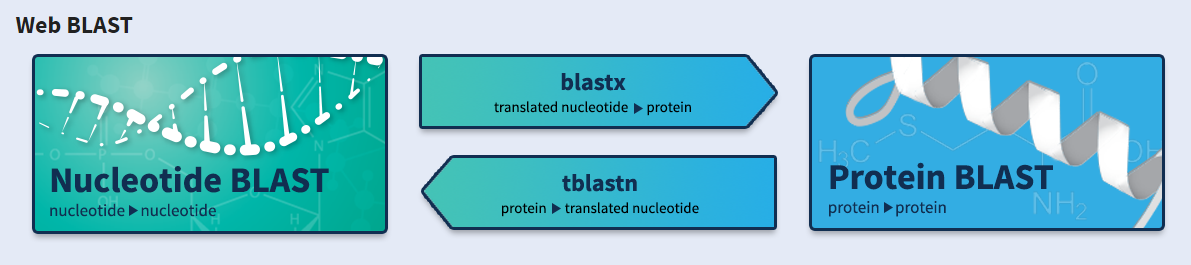

Once the databases are ready, we can launch the local blastn and blastx searches!

To see all the options you have for running local blastn or blastx, you can explore the help menu.

Commonly used arguments that you need to know include (definitions taken from Blast+ 's official documentation):

**Alignment:** (within the context of blast) Represents the region where query and subject sequences match completely or have significant similarity.

**Hit:** A hit is a subject sequence that is similar to a query sequence above a certain threshold. When blast searches a database with a query sequence, it identifies the subject sequences that contain regions of similarity to the query. Each of the subject sequences identified is a "hit". While a hit is the subject sequence that matches the query, the alignment is the specific region of similarity within that hit. 

**e-value:** Describes the number of hits expected by chance when searching a database of a particular size. It decreases exponentially as the score of the match increases, meaning that the lower e-value is, the more significant the hit is (as the number of hits expected by chance are almost non-existent). Beware, short alignments have high e-values because shorter sequences have a higher probability of occurring in the database purely by chance. Evalues also depend on the size of the database, with larger databases resulting in more false positives by chance and more significant e-values for the same hit in smaller databases. Comparing e-values resulting from searching databases from different sizes is incorrect. For that, you can use bitscores, which are not affected by database sizes.

**Bitscore:** Not an argument but you will see it in the results. Bitscore is a log2 scaled score that can be interpreted as the size of the database needed to get a hit by chance. The larger the bitscore the better. It has the advantage that it can be compared across different blast+ runs and it does not depend on the size of the database used for the search or the length of the query sequence.

**Percentage of identity:** The percentage of positions (nucleotide or amino acid) in two aligned sequences (query and subject) that have the same residues. Identity does not include gaps in the alignment. Keep in mind that a high percentage of identity is more likely for a short alignment. It is not the same to have a 500 bases long alignment with 100% of identity between the two sequences to have a 10 bases long alignment with 100% of identity.

**Maximum hsps:** An HSP is a High-scoring Segment Pair, or a high-scoring alignment between two sequences. It is possible to have more than one hsp between two sequences when, for example, the query matches two segments of the same subject (or the other way around). That means multiple hsps alignments per hit. Different hsps within a hit can (and will most likely) have varying scores. This argument sets the maximum number of hsps to keep for any single hit. If `max_hsps` is set to two, only two hsps for that particular hit (subject sequence that matches) will be reported even if there are four possible hsps in that same hit.

**Number of alignments:** Sets the maximum number of alignments to hits If set to 10, the results will report up to 10 different alignments to the subject sequences that matches the query. This argument is used for output formats that are hierarchical and have the alignments in their output, e.g. json, html, or `-outfmt <= 4`

**Maximum number of target sequences:** Sets the maximum number of different subject sequences that are reported as hits. If set to 10, the **first** 10 hits **that exceed the evalue threshold** to subject sequences are shown (ask yourself if that is enough for your research question, also, those 10 pass the threshold but might not be the **best** hit). It should be used with report formats that do not have separate definition line and alignment sections (so, suitable tabular data which ignores the actual alignment in the output or `-outfmt > 4`). You can still have multiple hsps for each hit in your output. Because this parameter has been a source of confussion on the field, I reiterate that it returns the N hits to different subject sequences, not the N best/top N hits to different subject sequences. Which hits are reported depend on the order in which sequences ocurr in the database and the hits reported will change with different databases. If you are doing homology-related research... be really carefull and always set this to be a high number so that you are sure you are capturing the best hits. This behaviour applies to the command line versions of blast+.

**outfmt:** If it is 6 (tabular-delimited), then the default headers of the tabular delimited file are:
- qseqid or query sequence ID
- sseqid or subject sequence ID
- pident or percentage of identity
- length or length of the alignment
- mismatch or number of mismatches within the alignment
- gapopen or the number of gap openings (no their length)
- qstart or the start of the alignment with respect to the query sequence
- qend or the end of the alignment with respect to the query sequence
- sstart or the start of the alignment with respect to the subject sequence
- send or the end of the alignment with respect to the subject sequence
- evalue is defined above
- bitscore is defined above
  
We are adding these two:

- staxids or the taxonomic ID code used on NCBI
- sscinames or the scientific name when it is available

You can find more information [here](https://www.ncbi.nlm.nih.gov/books/NBK279684/table/appendices.T.options_common_to_all_blast/)

We will run blastn (nucleotide queries vs. nucleotide subjects) for the **fish sample you have been working with up to now** and for the **metagenomic** sample.

Then, we are running blastx (translated nucleotide queries vs. protein subjects) to try and find toxin-antitoxin-related proteins in the metagenomic data (and who knows, maybe discover something cool?)

**Running blastn for your fish sample:**

In [ ]:
%%bash

conda deactivate;
conda activate biogenomics;

# in case you forget to do this:
# make sure the path is correct!
export BLASTDB="/mnt/c/Users/mftor/Documents/bioinfo4evol/practicals/lecture4/blobtools";

# running from the meta folder but input and output will be in the "meta" folder
blastn -help

# running everything from the meta folder
cd ../meta 

# hort reads, continue working with the same sample you chose
INPUT='SRR21290998_out/scaffolds.fasta'

# for the sake of the exercise we are using max_hsps 1 but this number should be higher!!! 
# we only need one hsps to annotate the taxonomy in the query sequence if there is a hit, any more hsps for the same hit will have the same taxonomy :)

blastn -db bacteria.fasta -evalue 1e-5 -perc_identity 30 -max_hsps 1 \
    -num_threads 4 -outfmt "6 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore staxids sscinames" \
    -out ../short/"${INPUT%_out/*.*}"_bn_bacteria.out -query ../short/$INPUT

### 4.4 Blast+ searches on the metagenomic contigs

Now, let's try to see how many contigs we have from the metagenomics data. We will be able to identify contigs that might be similar enough to other sequences in the database and thus, derive their likely taxonomic identity from that. **Only with regards to potential taxonomic identity based on sequence homology**, I would consider contigs with **>98%** identity to a sequence in the database to at least be the subject's genus.

That rule of thumb changes depending on the taxon you work with, the length of the match between query and subject, and the taxa represented in the database. Always keep in mind what is the rule of thumb on your field and read papers on molecular species delimitation of your taxon to get a better idea of what a good percentage of identity is.

When it comes to proteins, I would consider **>70%** identity between subject and query to be a good match between my contigs and the protein sequences in the database for two reasons: **1)** the nucleotide sequence corresponding to a protein might vary much more as you go higher in the taxonomic ranks (e.g. at the genus or family level); and **2)** The protein databases are less likely to have a good representation of all possible proteins in all possible species. So, you might never get a >98% identity between your query and the subject just because your species' protein sequences are not available in the database.

**When evaluating sequence homology for functional or evolutionary applications**, percentage of identity is not the best metric. Your query sequence might have 100% identity to only a partial section of the subject's sequence that represent a 10% of the entire subject's sequence length. I recommend you read [Pearson, 2014](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3820096/).

Our objective right now is simply to assign a potential taxa identity to our contigs and run a preliminary rough analysis on the taxa and toxin composition of the metagenomic data.

**Running blastn with the metagenomic data**

In [ ]:
%%bash

conda deactivate;
conda activate biogenomics;

# in case you forget to do this:
# make sure the path is correct!
export BLASTDB="/mnt/c/Users/mftor/Documents/bioinfo4evol/practicals/lecture4/blobtools";

# assign input file to INPUT variable
INPUT='SRR18246873_out/scaffolds.fasta'

blastn -db bacteria.fasta -evalue 1e-5 -perc_identity 30 \
    -num_threads 4 -outfmt "6 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore staxids sscinames" \
    -out "${INPUT%_out/*.*}"_bn_bacteria.out -query $INPUT


**Running blastx for the metagenomic data**

In [ ]:
%%bash

conda deactivate;
conda activate biogenomics;

# in case you forget to do this:
# make sure the path is correct!
export BLASTDB="/mnt/c/Users/mftor/Documents/bioinfo4evol/practicals/lecture4/blobtools";

# assign input file to INPUT variable
INPUT='SRR18246873_out/scaffolds.fasta'

# blastx has different options
blastx -help

blastx -db toxin.fasta -evalue 1e-5 -max_hsps 1 -max_target_seqs 10 \
    -num_threads 4 -outfmt "6 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore staxids sscinames" \
    -out "${INPUT%_out/*.*}"_bx_toxin.out -query $INPUT

### 4.5 Using blobtools to identify contamination


Now, we will use the coverage information we have (clean reads mapped to draft assembly as a BAM file), the results from the blastn searches (only against a Bacteria subject database), and the draft assemblies to identify contigs in our fish assemblies that belong to bacterial contaminations. 

For this, we will follow [blobtools's instructions](https://blobtools.readme.io/docs/my-first-blobplot).

Blobtools uses blastn's output to assign a taxonomic rank to each of the query contigs. The file we need as input requires three mandatory columns:

- 1st column: sequenceID (must be part of the assembly) == contig names or **qseqid**
- 2nd column: TaxID (a NCBI TaxID) == taxonomic rank of the hit or **staxids**
- 3rd column: score (a numerical score) == a score comparable across blastn searches or **bitscore**

<div class="alert alert-block alert-success">
<b>TO DO: </b>Use the Linux commands you have learnt to select the correct columns from the blastn output (of your fish and the metagenomic data) and create the three-column input file required by blobtools. Blastn's output doesn't have a header but you will find the order of the columns if you look at the command you ran. <b>You will need this file to continue</b>.</div>

**Solution** hidden here (but seriously, try doing it yourself first.
<!-- 

blast's output header should be:
qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore staxids sscinames 

cut command is 1-indexed, so, the first column in a file has index 1

cut -f1,13,12 SRR18246873_bn_bacteria.out > SRR18246873_bacTaxID.txt

it might be possible that you don't get hits or that your hits have very low bitscores
-->

In [ ]:
%%bash

# creating blobs for the metagenomic data

cd ../meta

conda deactivate
conda activate blobtools

INPUT='SRR18246873'

samtools sort -@ 4 cov_${INPUT}.bam | samtools coverage - | cut -f1,4,5 > cov_${INPUT}.cov

blobtools create \
    -i ${INPUT}_out/scaffolds.fasta \
    -c cov_${INPUT}.cov \
    -t ${INPUT}_bn_bacteria.out \
    -o "${INPUT}".blobplot

mkdir "${INPUT}"_bb

blobtools view \
    -i ${INPUT}.blobplot.blobDB.json \
    -o "${INPUT}"_bb/

blobtools plot \
    -i ${INPUT}.blobplot.blobDB.json \
    -o ${INPUT}_bb/

**The metagenomics data**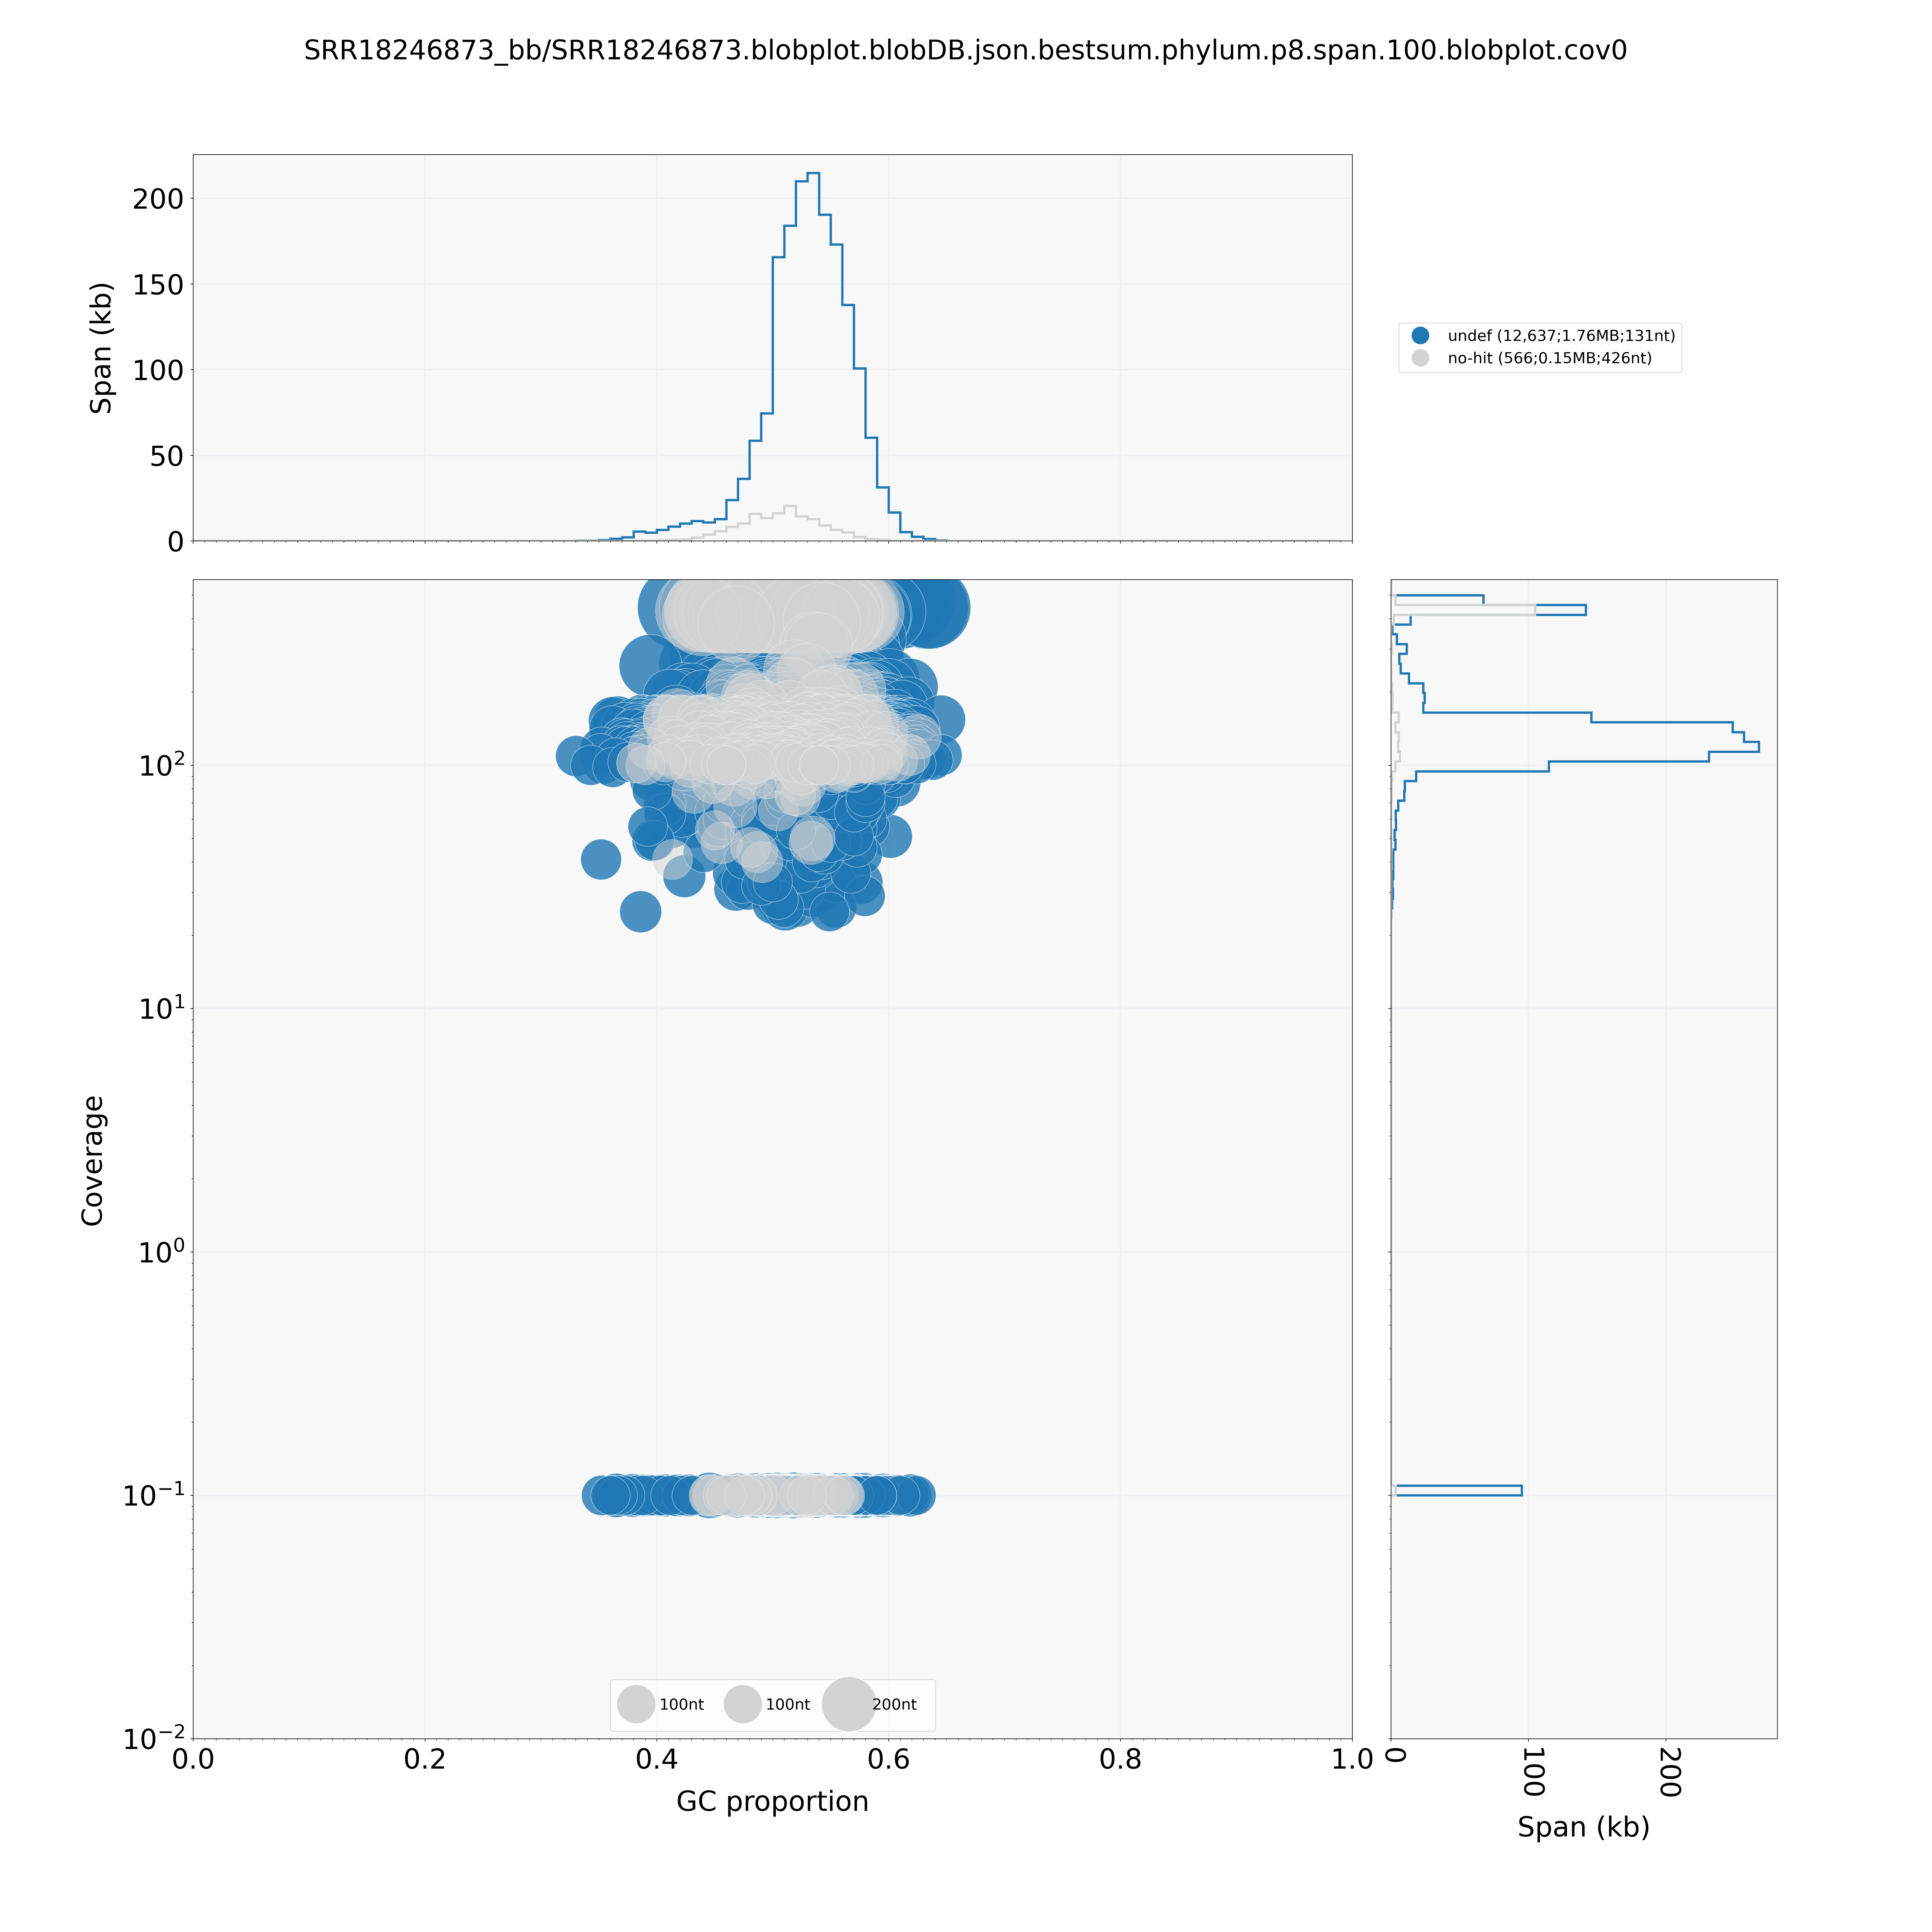



**One of the fish samples**

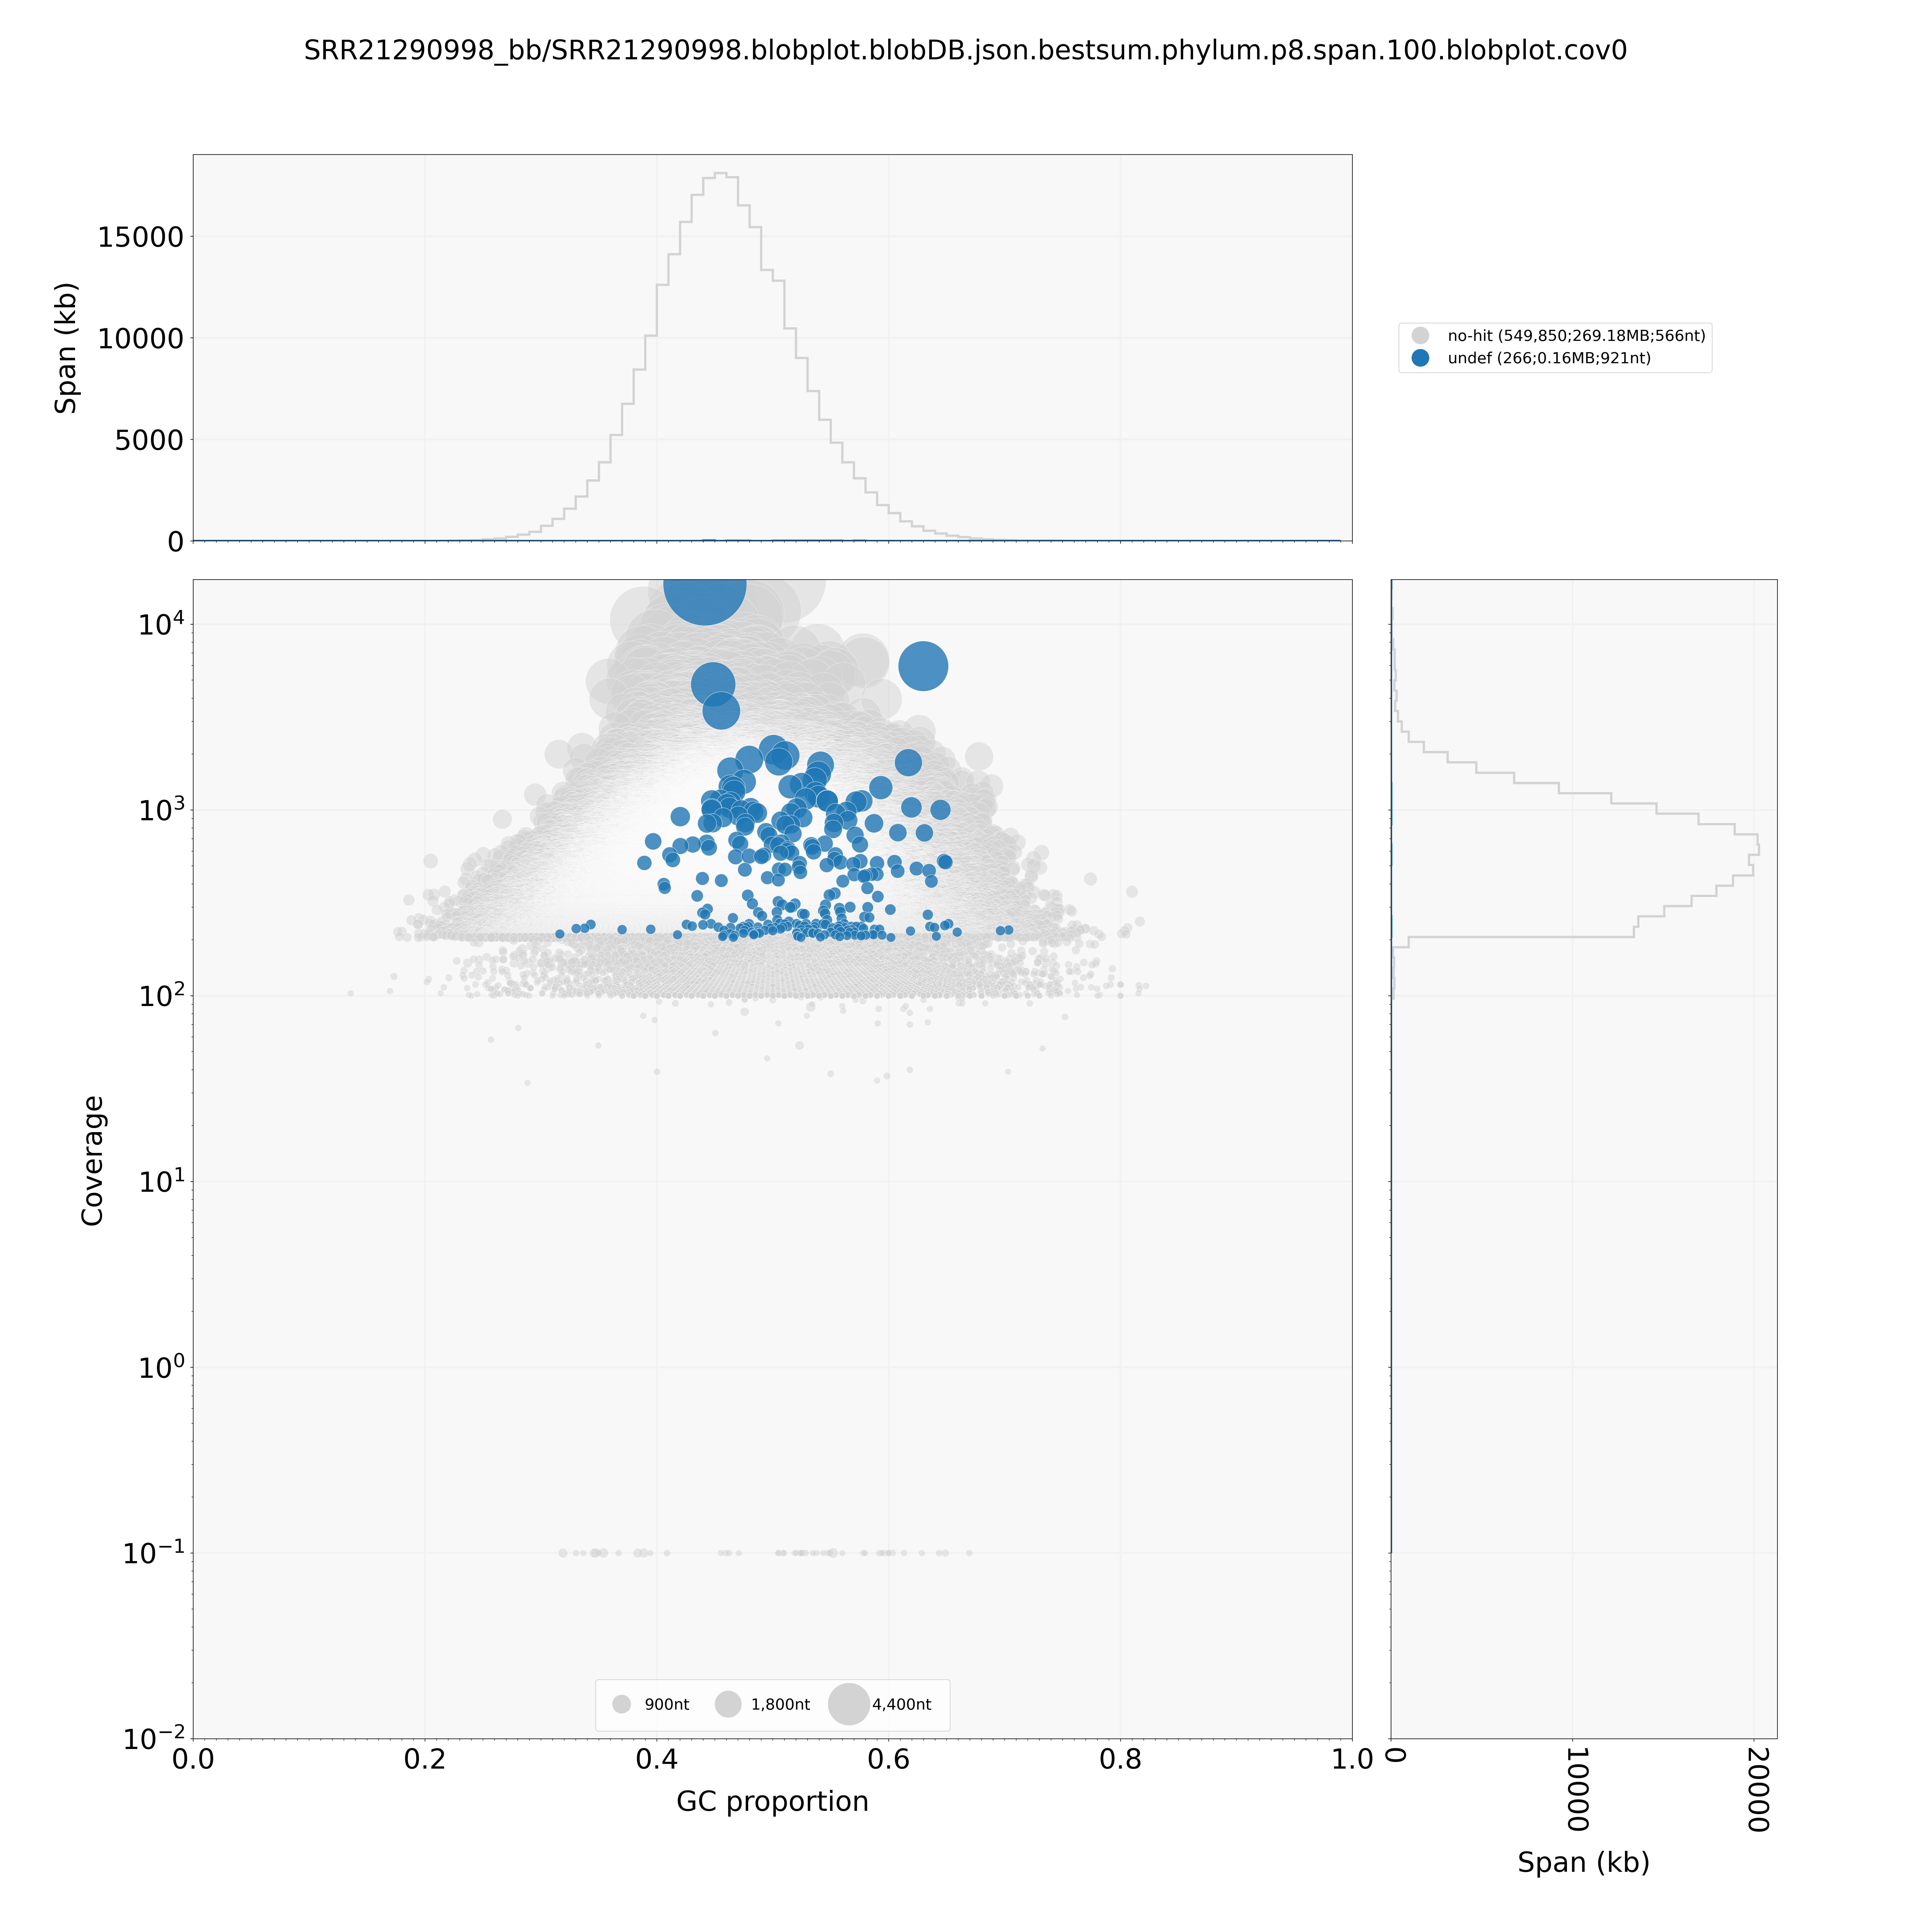

#### 4.5.1 Filtering the reads that are contamination

Our samples don't show much contamination but there might be cases where high contamination is the case. Besides looking for contamination, these analyses can help you identify contigs belonging to the mitrochondrial or chloroplast genome, or to have an initialidea of the taxonomic composition of an environmental sample (when the subject database contains representatives from all taxa).

Whatever is the application and at this point, you might have identified a list of contigs that you want to keep for further analyses. For example, contigs that are of your taxon of interest (vertebrate or fish in our case) or for which you have no evidence of contamination (no-hit or depending on your choice, undefined). You will then filter the reads that make up the selected contigs and proceed with a more careful assembly of the reads you kept. Other applications can be to keep contigs with disproportionally high coverage to assemble the potentially mitochondrial or chloroplast genome. Or if you are sequencing symbiont associations (host and symbiont), you can separate the contigs from the host and the symbiont and assemble their genomes separatedly.

to remove the undefined (undef) contigs and the reads that make up those contigs from our data:


<div class="alert alert-block alert-success">
<b>TO DO: </b>Look at the SAMPLE_bb folder where blobtools' output is generated. Look at the <i>blobplot.blobDB.table.txt</i> file. Use the Linux commands you have learnt to create a list of contigs with <i>phylum</i> annotated as "undef". Give the file the name <i>remove_contigs.txt</i> - <b>You will need this file to continue</b>.</div>

**Solution** hidden here (but seriously, try doing it yourself first.
<!-- 

# check how it looks like
# using the metagenomic data as example
cd ../meta
cat SRR18246873_bb/SRR18246873.blobplot.blobDB.table.txt | head -n 20

# building the code one pipe at a time
grep 'undef' SRR18246873_bb/SRR18246873.blobplot.blobDB.table.txt | head

grep 'undef' SRR18246873_bb/SRR18246873.blobplot.blobDB.table.txt | cut -f1 | head
grep 'undef' SRR18246873_bb/SRR18246873.blobplot.blobDB.table.txt | cut -f1 > remove_contigs.txt

# 39514 remove_contigs.txt to keep
# 41309 total contigs in SRR18246873_bb/SRR18246873.blobplot.blobDB.table.txt
-->

Let's filter out the contigs. Always think about what you are filtering out and ask yourself if that makes sense given your data and your research question.

In [ ]:
%%bash

conda deactivate
conda activate blobtools

cd ../meta

INPUT='SRR18246873'

blobtools seqfilter \
    -i ${INPUT}_out/scaffolds.fasta \
    -l remove_contigs.txt \
    -o "${INPUT}"_kept

blobtools seqfilter \
    -i ${INPUT}_out/scaffolds.fasta \
    -l remove_contigs.txt \
    -o "${INPUT}"_removed \
    -v

The last couple of steps will be to map the reads back to the kept or removed contigs (depending on what your research question requires) and generate a BAM file with the read-contig alignments. From there, you can extract the reads from the BAM file and create a fastq file with them to use them as input for your new assembly. Up to now, you will have removed systematic (adapters, poly-g) and exgonenous (not your sample) contamination.